# Demo usage of GIST

To show case how GIST can be used, we created this notebook. We will show a simple example using the Text based models with 12 models acting as our reference benchmark and one xlnet being used as a model under test we want to tranfer the test set on.

We kept the code as general as possible, so you should be able with a few modification to adapt it to your context. We create two repositories 'm' and 'm_o' to put the data needed. In our case, in 'm' we put the features extracted on the trained data for each model (in order to use the representational/functional similarities) and in 'm_o' we put the covered clusters by each reference model on the objective model. You can thus adapt it to your case, by providing data that act as your 'm' and 'm_o'. For more detail, check our paper.

## Setup

As we mentioned, we will 12 text models as reference: 3 bert, 3 electra, 3 distill and 3 roberta. Once we tuned GIST based on those models (following the procedure we detail in our paper), we will use an XLNet as our objective model.

In [28]:
# Imports
import json
import os

import numpy as np
from scipy.special import kl_div
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

# definition of the models
ref_mods = ['electra', 'distill', 'bert', 'roberta']
obj_mods = ['xlnet']

## Offline phase (benchmark)

This part is similar to RQ3 in our paper: to pick the correct 'm' to act as a proxy to 'm_o', we will pick one model from our reference models to act as an objective model. We then calculate the correlations using the data calculated from 'm' and 'm_o'. Each reference model will act as an objective models. We will then check that the correlation holds for a majority of objective model, to establish that 'm' is a proxy of 'm_o' for the reference benchmark

### Loading benchmark

Loading the data accordingly. This where you should adapt the code. In our case, we load the .json files of the covered clusters and the .npz array for the features extracted on the trained data

In [2]:
# Loading our benchmark data
# Fault types data (for M_O)
fault_types = {}

files = os.listdir('m_o')
# Loading all files except "xlnet" which will be used as objective model in "online" model for demonstration 
file_list = [f for f in files if obj_mods[0] not in f and 'demo' in f]
for f in file_list:
    with open(os.path.join('m_o', f), 'r') as temp:
        fault_types[f.split('cluster')[1][1:].split('.')[0]] = dict(json.load(temp))

# Train representation (features and predictions) (for M)
pred = {}
# x_flat = {}
files = os.listdir('m')
# Loading all files except "xlnet" which will be used as objective model in "online" model for demonstration 
file_list = [f for f in files if obj_mods[0] not in f]
for f in file_list:
    temp = np.load(os.path.join('m', f))
    pred[f.split('train')[0][:-1]] = temp['pred']
    # If we were to use representational features, we would also load them
    # Here, we will stick to one functional similarity as m for simplicity sake
    # x_flat[f.split('gen')[0][:-1]] = temp['x_flat']
del temp


## Defining M and M_O

We define the two functions to calculate M and M_O. For M_O, we implement it as in our paper (the fault type coverage). For M, we just implemented the J Divergence, as it yieleded best results. Obviously, you could also have multiple M as we did in the paper to find which of your metrics works best as a proxy of your M_O

In [3]:
# m_o function (property to tranfer): calculate the fault type coverage of the test set of ref_model on the clusters obtain on the objective model
def m_o(clusters_on_obj_model, ref_model):
     return len(set(clusters_on_obj_model['list_covered_clusters_ref_'+str(ref_model)]) & set(clusters_on_obj_model['list_covered_clusters_obj']))/len(clusters_on_obj_model['list_covered_clusters_obj'])

# Custom: Implement your function m_o for the property you want to transfer
# ...

# m function (proxy to evaluate): we could evaluate all the metrics (representational and functional) we described in the paper
# For the sake of simplicity, we just implement here the J Div that gave good results on the text procedure.
def m(obj_train_model_feat, ref_train_model_feat):
     
     A = np.abs(obj_train_model_feat)
     B = np.abs(ref_train_model_feat)
     return np.mean([kl_div(A[i],B[i]) + kl_div(B[i],A[i]) for i in range(len(A))])/2

# Custom: Implement your function m for the proxy you want to evaluate
# ...

### Running the correlation

We calculate the correlation with Kendall's tau. To determine whether the correlation is okay, we check for a correlation > 0.2 and p-val < 0.1. We could require lower p-val and/or higher correlation, but in this example we are using very few examples, so it might be harder to get those values. This is of course case dependant.

In [4]:
is_not_ok_corr = []
is_not_ok_p_val = []

# We now benchmark: for each reference model, we pick one as an objective model and evaluate the correlation between m and m_o
# using the other reference model
# The aim, as we explain in the paper, is to establish whether m is a good proxy of m_o for that procedure
for i in range(len(ref_mods)):
    for k in range(1, 4):
       f_c_list = []
       sim_list = []
       for j in range(len(ref_mods)):
            # Not accounting for same model type (e.g. if BERT is objective model, no reference model can be BERT)
            if ref_mods[i] == ref_mods[j]:
                continue        
            for l in range(1, 4):
              # Fault types coverage on objective model ref_mods[i]_k using test set of model ref_mods[j]_l
              f_c_list.append(m_o(fault_types[ref_mods[i]+'_demo_'+str(k)], ref_mods[j]+'_demo_'+str(l)))
              # Functional similarity between objective model ref_mods[i]_k using test set of model ref_mods[j]_l
              sim_list.append(m(pred[ref_mods[i]+'_demo_'+str(k)], pred[ref_mods[j]+'_demo_'+str(l)]))
       res_corr = kendalltau(sim_list, f_c_list)
       # We check whether the correlation is too low (here, set to 0.2 so weak/medium correlation)
       # or p-value not significant at the 90% threshold
       if res_corr[0] > -0.2:
           is_not_ok_corr.append(ref_mods[i]+'_demo_'+str(k))
       elif res_corr[1] > 0.1:
           is_not_ok_p_val.append(ref_mods[i]+'_demo_'+str(k))

print("Objective model leading to low correlation: ", is_not_ok_corr)  
print("Objective model leading to p-value not significant: ", is_not_ok_p_val)            

Objective model leading to low correlation:  []
Objective model leading to p-value not significant:  ['roberta_demo_2', 'roberta_demo_3']


We see that, in term of correlation, all objective model yieleded a good enough correlation. For the p-val, two roberta models did not achieve the threshold. This is however not too surprising as we are using few seeds, as well as roberta model acting different than bert, distill and electra (see RQ1/RQ2). For this example, the result are convincing enough to say that J Divergence is a good proxy of fault type coverage.

Note: In your case, we recommend (as we did in the actual experiments) to use as many seeds and as many model types as possible to avoid those problematic case

# Online Phase

Here, we will pick the XLNet model and put ourself in the context where we just trained the model and want to transfer a test set from our reference benchmark. In that case, we only have access to information for M (the proxy)

### Loading the data

Adapt it just as in the Offline Phase

In [14]:
# Train representation (features and predictions) (for M)
files = os.listdir('m')
# Loading the objective model "xlnet" features 
file_list = [f for f in files if obj_mods[0] in f and 'xlnet_demo_1' in f]
temp = np.load(os.path.join('m', file_list[0]))
pred_obj = temp['pred']
del temp

### Calculate most similar

We calculate similarity using the proxy J divergence and then rank the obtained results

In [13]:
sim_list = {}
for i in range(len(ref_mods)):
    for k in range(1, 4):
        sim_list[ref_mods[i]+'_demo_'+str(k)] = m(pred_obj, pred[ref_mods[i]+'_demo_'+str(k)])

sorted_sim = {k: round(v,3) for k, v in sorted(sim_list.items(), key=lambda item: item[1])}
print("Models sorted by similarity: ", sorted_sim)       

Models sorted by similarity:  {'roberta_demo_2': 0.104, 'roberta_demo_1': 0.108, 'roberta_demo_3': 0.11, 'bert_demo_2': 0.134, 'bert_demo_1': 0.139, 'distill_demo_2': 0.144, 'distill_demo_1': 0.145, 'distill_demo_3': 0.145, 'bert_demo_3': 0.151, 'electra_demo_1': 0.203, 'electra_demo_2': 0.213, 'electra_demo_3': 0.223}


The result shows that we should choose the test set from the roberta_demo_2 as the test set to transfer, since it leads to the best similarity (J Divergence is a distance, so lower is better).

## Verification

In practice, we will not be able to do a verification as we won't be able to have access to M_O for the XLNet (it's afterall the point of GIST through choosing the proxy). Nonetheless, we can verify in our case that choosing the test set from roberta_demo_2 is good. To do so, we can cluster the reference test sets with the test set from XLNet using XLNet information and the clustering approach described in our paper.

### Loading the data

We precalculated the clusters.

In [23]:
fault_types = {}

files = os.listdir('m_o')
# Loading all files except "xlnet" which will be used as objective model in "online" model for demonstration 
file_list = [f for f in files if 'xlnet' in f and 'demo' in f]
with open(os.path.join('m_o', file_list[0]), 'r') as temp:
    fault_types = dict(json.load(temp))

### Calculating the fault type coverage

In [26]:
f_c_list = []
sim_list = []

for i in range(len(ref_mods)):
    for k in range(1, 4):
       
       # Fault types coverage on objective model ref_mods[i]_k using test set of model ref_mods[j]_l
       f_c_list.append(m_o(fault_types, ref_mods[i]+'_demo_'+str(k)))
       # Functional similarity between objective model ref_mods[i]_k using test set of model ref_mods[j]_l
       sim_list.append(m(pred_obj, pred[ref_mods[i]+'_demo_'+str(k)]))

We can verify in passing that the correlation is good in that case

Note the correlation is negative since for J Div lower is better (in the paper, we put it as positive to compare with other metrics such as PWCCA, CKA and Ortho)

In [27]:
kendalltau(sim_list, f_c_list)

SignificanceResult(statistic=-0.5002443195845779, pvalue=0.026500280602491877)

### Plotting

Plotting the fault type coverage function of the similarity. We color the data points based on which model they come from

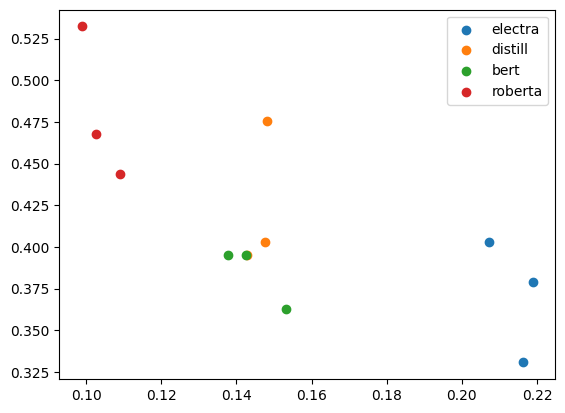

In [29]:
for i, mod in enumerate(['electra', 'distill', 'bert', 'roberta']):
   plt.scatter(sim_list[i*3:i*3+3], f_c_list[i*3:i*3+3], label=mod)
plt.legend()
plt.show()

The first data point corresponds to the test set from roberta_demo_2. In that case, it's the best test set we have access to for the fault type coverage property (who lead to a Top-1 value of 0%, i.e. no other test is better). The two following most simiar model are also roberta's and one can see they are also among the best. The other data point start being not as good, even though they remain better tham picking at random. This shows the practicality of the method.